# Prosper Loan Data Exploration

## Table of Contents
<ul>
<li><a href="#wrangle">Preliminary Wrangling</a></li>
<li><a href="#univariate">Univariate Exploration</a></li>
<li><a href="#bivariate">Bivariate Exploration</a></li>    
<li><a href="#multivariate">Multivariate Exploration</a></li>
<li><a href="#conclusion">Conclusions</a></li>
</ul>

## Introduction
> The loan dataset from Prosper contains 113,937 records with 81 variables for each loan record, including loan amount, borrower rate (or interest rate), current loan status,
borrower income, and many others.

> I will not be using all the records and variables. The documentation states that some variables, including some of my variables of interest, are only populated after July 2009. So, I will be using only those records from after July 2009.

<a id='wrangle'></a>
## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# load the dataset into a dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# check the high level overview
print(df.shape)
print(df.head())

(113937, 81)
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   

  CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
0           C    36  Completed  2009-08-14 00:00:00      0.16516   
1         NaN    36    Current                  NaN      0.12016   
2          HR    36  Completed  2009-12-17 00:00:00      0.28269   
3         NaN    36    Current                  NaN      0.12528   
4         NaN    36    Current                  NaN      0.24614   

   BorrowerRate  LenderYield  ...  LP_ServiceFees  LP_CollectionFees  \
0        0.1580       0.1380  ...         -133.18

In [4]:
# select records from after July 2009
# from documentation 'CreditGrade' is populated pre-2009. Select only the records which has Null value in this field.
df = df.loc[df['CreditGrade'].isnull()]

In [5]:
# check for duplicates
sum(df.ListingKey.duplicated())

871

In [6]:
# remove duplicates since the number is very very small when compared to the total number of records
df = df.drop_duplicates(subset=['ListingKey'], keep='first')

In [7]:
# display duplicates if any
df[df.duplicated(['ListingKey'], keep=False)]

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors


In [8]:
# convert 'BorrowerRate' and 'EstimatedReturn' to percent
df['BorrowerRate'] = df['BorrowerRate']*100
df['EstimatedReturn'] = df['EstimatedReturn']*100

In [9]:
# calculate 'CreditScoreAverage' from 'CreditScoreRangeLower' and 'CreditScoreRangeUpper'
df['CreditScoreAverage'] = (df['CreditScoreRangeLower'] + df['CreditScoreRangeUpper'])/2

In [10]:
# convert 'ProsperRating' and 'IncomeRange' into ordered categorical types
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
          'IncomeRange': ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [11]:
# create a list of variables of interest
numeric_vars = ['EstimatedReturn', 'BorrowerRate', 'CreditScoreAverage', 'DebtToIncomeRatio', 'LoanOriginalAmount']
categoric_vars = ['ProsperRating (Alpha)', 'ProsperScore', 'Term', 'IncomeRange']

In [12]:
# check for null values in categorical variables
df[categoric_vars].isnull().sum()

ProsperRating (Alpha)    131
ProsperScore             131
Term                       0
IncomeRange                0
dtype: int64

In [13]:
# 'ProsperScore' is one of the key variables of interest
# drop records with null value for 'ProsperScore' and convert it into int
df = df.dropna(subset=['ProsperScore'])
df['ProsperScore'] = df['ProsperScore'].astype(int)

In [14]:
# make sure all the records with null values are removed
df[categoric_vars].isnull().sum()

ProsperRating (Alpha)    0
ProsperScore             0
Term                     0
IncomeRange              0
dtype: int64

In [15]:
# check the final count of records
df.shape[0]

83982

In [16]:
# check the descriptive statistics for numeric variables of interest
df[numeric_vars].describe()

,EstimatedReturn,BorrowerRate,CreditScoreAverage,DebtToIncomeRatio,LoanOriginalAmount
count,83982.000000,83982.000000,83982.000000,76768.000000,83982.000000
mean,9.624590,19.630014,708.976316,0.258692,9061.224381
std,3.047472,7.475005,47.185610,0.319727,6279.649648
min,-18.270000,4.000000,609.500000,0.000000,1000.000000
25%,7.463000,13.590000,669.500000,0.150000,4000.000000
50%,9.211000,18.750000,709.500000,0.220000,7500.000000
75%,11.710000,25.740000,729.500000,0.320000,13500.000000
max,28.370000,36.000000,889.500000,10.010000,35000.000000


### What is the structure of your dataset?

> After wrangling, the final record count is 83,982. Even though the original dataset has 81 variables, I will be using only a few. 

> Numeric variables of interest
>- Estimated Return
>- Borrower Rate
>- Credit Score
>- Debt to Income Ratio
>- Loan Original Amount

> Categorical variables of interest
>- Prosper Rating
>- Prosper Score
>- Loan Term
>- Income Range
>- Loan Status

> Prosper Rating is an ordered factor variable with values:
>
> HR, E, D, C, B, A, AA <br>
> (worst) ——> (best) <br>

> Similarly, Prosper Score is a custom risk score built using historical Prosper data. The score ranges from 1-11, with 11 being the best, or lowest risk score.


### What is/are the main feature(s) of interest in your dataset?

> When it comes to loan, everyone is interested in the "interest rate", in particular about the factors or variables contributing to determine the interest rate. However, I want to take one step further. Since [Prosper](https://www.prosper.com/about) is also an investment company, wherein individuals and institutions can invest in the loans and earn attractive returns, I want to analyze this dataset from an investor's perspective. In other words, I want to find out **what characteristics of the loan contribute to higher return for the investor**.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The dataset contains **Estimated Return** for each loan. It is calculated by subtracting Estimated Loss from Estimated Effective Yield. Estimated Effective Yield is proportional to **Borrower's Interest Rate**. In a way, Estimated Return and Borrower's Interested Rate are related to each other. I will be analyzing their relationship using:

>- Loan characteristics: **Loan Amount, Term of Loan**
>- Borrower characteristics: **Credit Score, Income Range, Debt to Income Ratio**

> and determine the factors affecting the Estimated Return.

> In addition, the two proprietary fields: **Prosper Rating** and **Proper Score**, which I think will assist in my analysis.

<a id='univariate'></a>
## Univariate Exploration


I will start by looking at the main variable of interest Estimated Return.

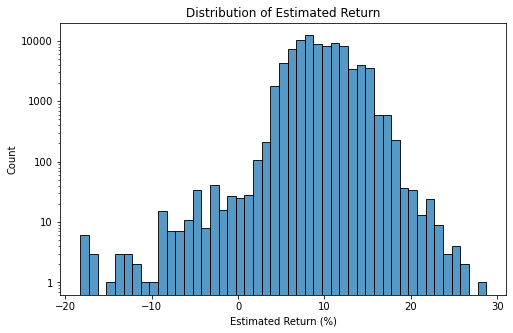

In [17]:
# Plot an histogram showing distribution of 'EstimatedReturn'

f, axes = plt.subplots(figsize = (8, 5))

# set the y-axis to log scale
axes = plt.gca()
axes.set_yscale('log', base = 10)
plt.yticks([10**i for i in range(5)],[10**i for i in range(5)])

# set the title and the labels
props = {
    'title': 'Distribution of Estimated Return',
    'xlabel': 'Estimated Return (%)',
    'ylabel': 'Count'
}
axes.set(**props)

# plot the graph 
sns.histplot(
    data = df,
    x = "EstimatedReturn",
    binwidth = 1
);

While the majority of the returns are over 0%, there are few returns that are negative. The distribution is slightly skewed left with peak at around 9%. 

Next, I will look at another variable of interest Borrower Rate.

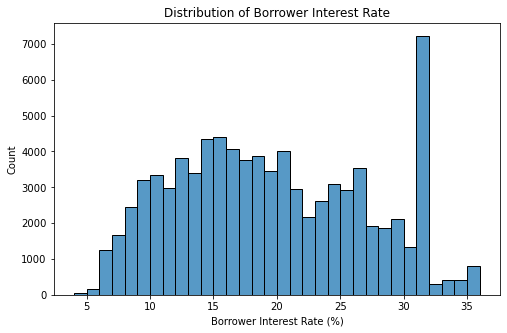

In [18]:
# Plot an histogram showing distribution of 'BorrowerRate'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Distribution of Borrower Interest Rate',
    'xlabel': 'Borrower Interest Rate (%)',
    'ylabel': 'Count'
}
axes.set(**props)

# plot the graph 
sns.histplot(
    data = df,
    x = "BorrowerRate",
    binwidth = 1
);

The interest rate ranges from 4% to 36% with multi-modal distribution. One peak is at around 15%, next at around 27% and the biggest spike is at 32%.

Over to the average Credit Score next.

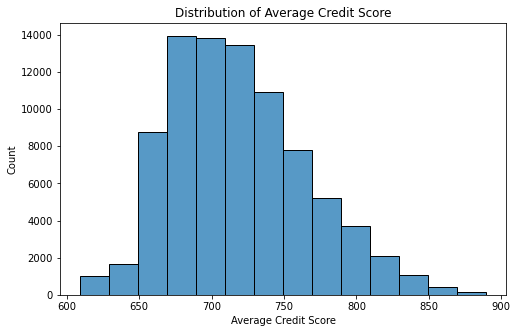

In [19]:
# Plot an histogram showing distribution 'CreditScoreAverage'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Distribution of Average Credit Score',
    'xlabel': 'Average Credit Score',
    'ylabel': 'Count'
}
axes.set(**props)

# plot the graph 
sns.histplot(
    data = df,
    x = "CreditScoreAverage",
    binwidth = 20
);

The average Credit Score follows a right skewed distribution with peak at around 700.

I will look at the Debt to Income Ratio next.

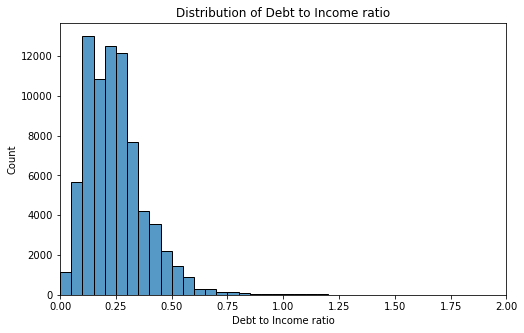

In [20]:
# Plot an histogram showing distribution of 'DebtToIncomeRatio'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Distribution of Debt to Income ratio',
    'xlabel': 'Debt to Income ratio',
    'ylabel': 'Count'
}
axes.set(**props)
axes.set_xlim(0,2)

# plot the graph 
sns.histplot(
    data = df,
    x = "DebtToIncomeRatio",
    binwidth = 0.05
);

Majority of the Debt to Income ratio falls between 0 and 1. The outliers on the higher end skew the distribution to the right.

Finally, the last numeric variable of interest Loan Original Amount.

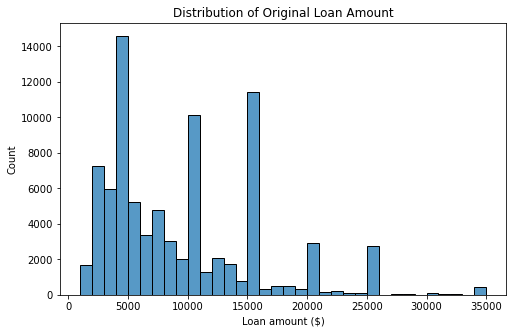

In [21]:
# Plot an histogram showing distribution of 'LoanOriginalAmount'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Distribution of Original Loan Amount',
    'xlabel': 'Loan amount ($)',
    'ylabel': 'Count'
}
axes.set(**props)

# plot the graph 
sns.histplot(
    data = df,
    x = "LoanOriginalAmount",
    binwidth = 1000
);

The loan amount ranges from 1000 to 35,000 with peaks at every 5000. Majority of the loans are for lower amounts making the distribution right skewed.

I will move on to the categorical variables next. 

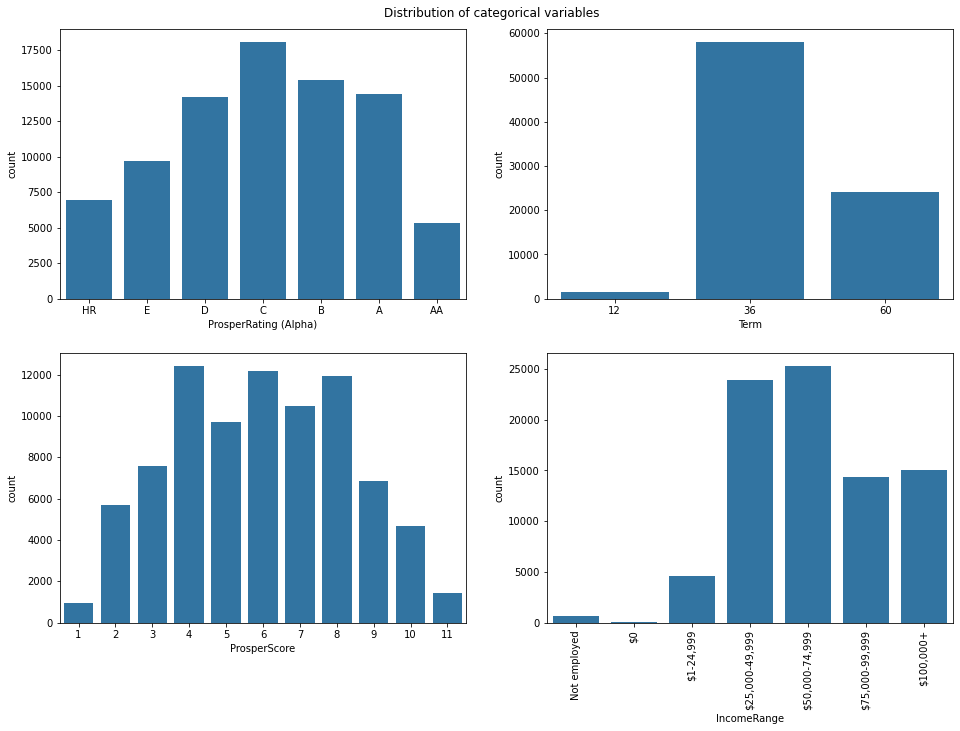

In [22]:
# Plot the distribution of 'ProsperRating (Alpha)', 'ProsperScore', 'Term' and 'IncomeRange'

f, axes = plt.subplots(2, 2, figsize = (16, 10))

# set the title
f.subplots_adjust(top=0.95)
f.suptitle("Distribution of categorical variables")

# set the default color
default_color = sns.color_palette()[0]

# plot the graph for 'ProsperRating (Alpha)'
sns.countplot(
    data = df, 
    x = 'ProsperRating (Alpha)', 
    color = default_color, 
    ax = axes[0,0]
)

# plot the graph for 'ProsperScore'
sns.countplot(
    data = df, 
    x = 'ProsperScore', 
    color = default_color, 
    ax = axes[1,0]
)

# plot the graph for 'Term'
sns.countplot(
    data = df, 
    x = 'Term', 
    color = default_color, 
    ax = axes[0,1]
)

# plot the graph for 'IncomeRange'
sns.countplot(
    data = df, 
    x = 'IncomeRange', 
    color = default_color, 
    ax = axes[1,1]
)

# rotate the x-axis ticks for 'IncomeRange'
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=90);


Prosper Rating shows a normal distribution with the peak at rating 'C'.

Prosper Score also shows normal distribution with slight dip at '5' and '7'.

Majority of the loans were provided for 36 months term followed by 60 months and very few loans were given for 12 months.

Regarding the Income Range, most of the borrowers earn between 25K and 75K.

Next, I want to look at the distribution of Loan Status. 

In [23]:
# count the loan by status
df.LoanStatus.value_counts()

Current                   55730
Completed                 19651
Chargedoff                 5336
Defaulted                  1005
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Name: LoanStatus, dtype: int64

In [24]:
# group all the 'Past Due' buckets into one
df['LoanStatusModified'] = df['LoanStatus'].str.split("\(").str[0]
df.LoanStatusModified.value_counts()

Current                   55730
Completed                 19651
Chargedoff                 5336
Past Due                   2057
Defaulted                  1005
FinalPaymentInProgress      203
Name: LoanStatusModified, dtype: int64

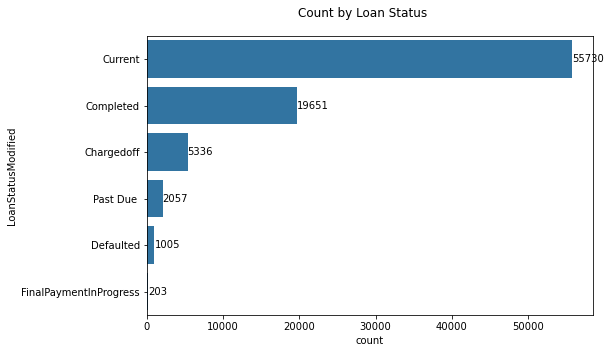

In [25]:
# Plot the distribution of 'LoanStatus' after combining the 'Past Due' buckets

f, axes = plt.subplots(figsize = (8, 5))

# set the title
f.subplots_adjust(top=0.9)
f.suptitle("Count by Loan Status")

# set the default color
default_color = sns.color_palette()[0]

# find the order of frequency
stat_order = df['LoanStatusModified'].value_counts().index

# plot the graph for 'LoanStatus'
sns.countplot(
    data = df, 
    y = 'LoanStatusModified', 
    color = default_color,
    order = stat_order
)

# print the count on the bar
stat_counts = df['LoanStatusModified'].value_counts()
for i in range(stat_counts.shape[0]):
    count = stat_counts[i]
    cnt_string = '{}'.format(count)
    plt.text(count+1, i, cnt_string, va = 'center');

Majority of the loans are in 'Current' status, followed by 'Completed' status. There are few thousand loans in 'Chargedoff', 'Past Due' and 'Defaulted' status. 

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> For Estimated Return, there were very few loans with negative return. I have to use log transformation on the y-axis to get an idea of number of loans with negative return.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I have to get rid of some records with null value for Prosper Score.

<a id='bivariate'></a>
## Bivariate Exploration

> First, I want to find the relationship among all the five numeric variables. I will be using plot matrices and correlation heatmap to do so.

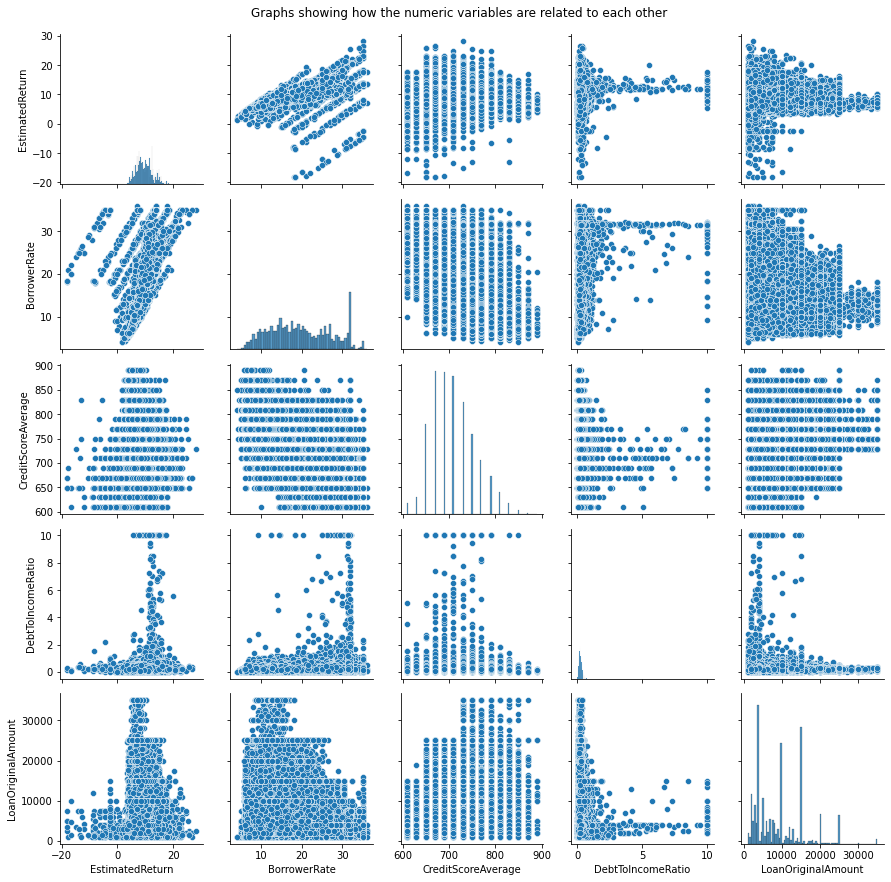

In [26]:
# Plot a graph matrix showing relationship among numeric variables

# plot the graph
g = sns.PairGrid(
    data = df, 
    vars = numeric_vars 
)
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

# set the title
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Graphs showing how the numeric variables are related to each other");


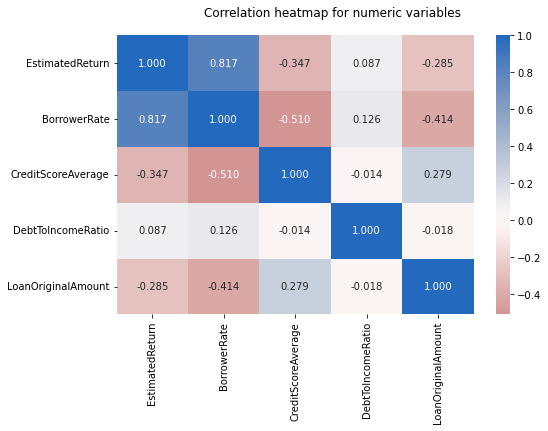

In [27]:
# plot the heatmap showing correlation between the numeric variables

f, axes = plt.subplots(figsize = (8, 5))

# set the title
f.subplots_adjust(top=0.9)
f.suptitle("Correlation heatmap for numeric variables")

# plot the graph
sns.heatmap(
    df[numeric_vars].corr(), 
    annot = True, 
    fmt = '.3f',
    cmap = 'vlag_r', 
    center = 0
);

As expected, the Estimated Return and Borrower Rate have a strong positive correlation. 

Credit Score has negative correlation with both Estimated Return and Borrower Rate, which makes sense - a borrower with higher credit score will get lower interest rate and hence the estimated return for the investor will be low. 

Debt to Income ratio doesn't have any noticeable correlation with other numeric values. So, I won't be considering Debt to Income ratio in my analysis going forward.

Loan Amount has a positive correlation with Credit Score - borrower with higher credit score gets larger loan amount. And because of that, its correlation with Estimated Return and Borrower Rate is negative.

Next, to the most important relationship between Estimated Return and Borrower Rate.

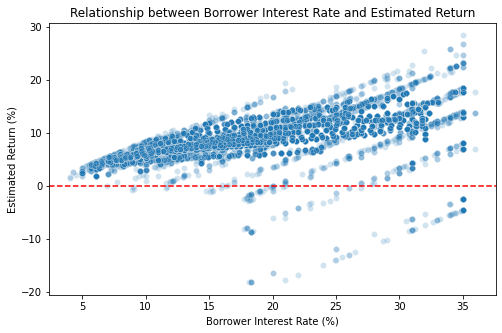

In [28]:
# Plot a scatterplot showing the relationship between 'BorrowerRate' and 'EstimatedReturn'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Relationship between Borrower Interest Rate and Estimated Return',
    'xlabel': 'Borrower Interest Rate (%)',
    'ylabel': 'Estimated Return (%)'
}
axes.set(**props)

# draw a line at 0 estimated return
axes.axhline(0, ls='--', color='red')

# plot the graph
sns.scatterplot(
    data = df,
    x = "BorrowerRate", 
    y = "EstimatedReturn",
    alpha = 1/5      
);

Generally, when the Borrower Rate increases, the Estimated Return increases at a slower pace. This is because some amount for fees, loss etc is subtracted from the interest rate before arriving at the estimated return. For 1 unit increase in the Borrower Rate, there is fraction of a unit increase in Estimated Return.

For few instances where the Estimated Return is below zero, the Borrower Rate is 18% or higher. In other words, negative Estimated Return is rare when the Borrower Rate is lower than 18%.

Next, I want to find out how the categorical variables relate to Estimated Return and Borrower Rate.

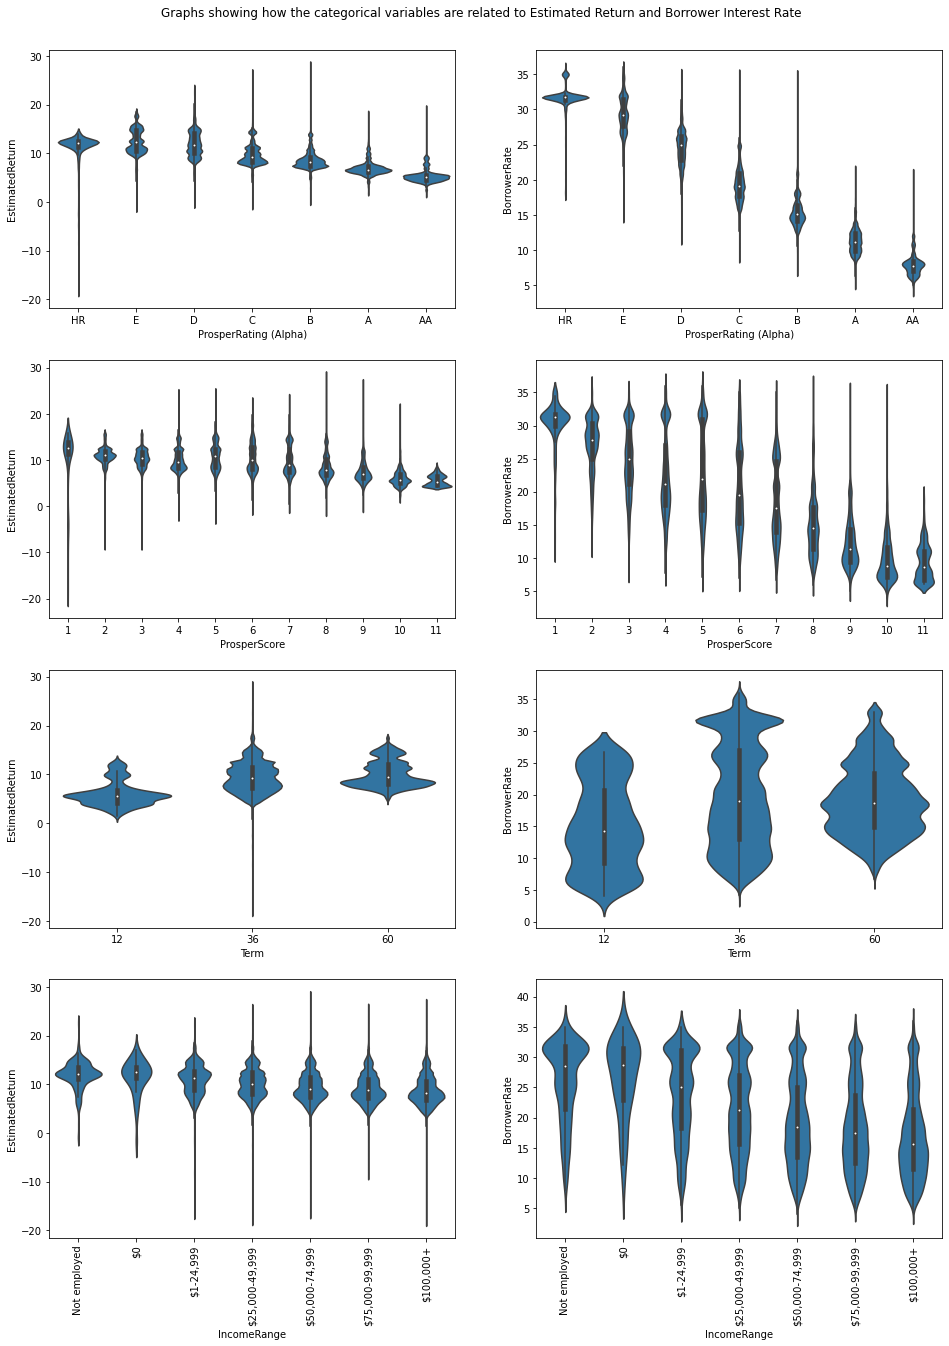

In [29]:
# Plot the categorical variables against 'EstimatedReturn' and 'BorrowerRate'

f, axes = plt.subplots(4, 2, figsize = (16, 20))

# set the title
f.subplots_adjust(top=0.95)
f.suptitle("Graphs showing how the categorical variables are related to Estimated Return and Borrower Interest Rate")

for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    sns.violinplot(
        data = df, 
        x = var, 
        y = 'EstimatedReturn', 
        ax = axes[i,0], 
        color = default_color
    )
    sns.violinplot(
        data = df, 
        x = var, 
        y = 'BorrowerRate', 
        ax = axes[i,1], 
        color = default_color
    )
    
axes[3,0].set_xticklabels(axes[3,0].get_xticklabels(), rotation=90)
axes[3,1].set_xticklabels(axes[3,1].get_xticklabels(), rotation=90);

There isn't any surprise when it comes to the Borrower Rate and the categorical variables. Lower interest rate is provided to best Prosper Rating, best Prosper Score, shorter Loan Term and higher income. The Prosper Rating has the most prominent change in Borrower Rate for each of its rating levels. Loan Term has the least prominent change in Borrower Rate for different loan terms.

The change in Estimated Return is not as prominent as we see in the Borrower Rate for different levels of each categorical variable. The Estimated Return increases a little bit in each level as we move from the best Prosper Rating or the best Prosper Score to the worst. However, worst Prosper Rating or Prosper Score is also characterized with negative Estimated Return outliers. 

Prosper Rating seems to be the best determinant of Borrower Rate or Estimated Return, followed by Prosper Score. This will be my area of focus in the multivariate exploration. Loan Term seems to be the least one, so I won't be considering Loan Term variable going forward.

Next, I want to explore the relationship among Prosper Rating, Prosper Score and Income Range.

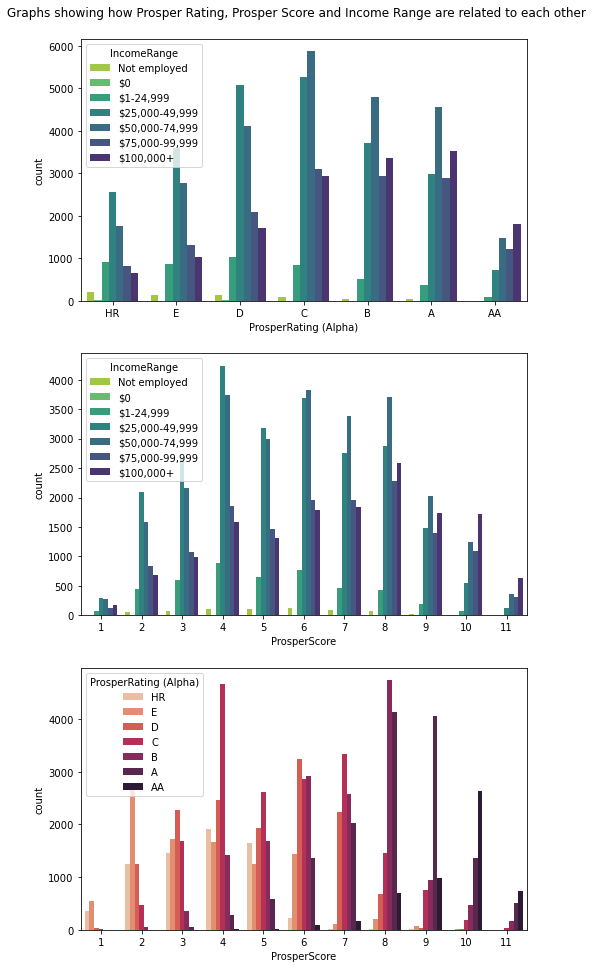

In [30]:
# Plot graphs showing how 'ProsperRating (Alpha)'', 'ProsperScore' and 'IncomeRange' are related to each other

f, axes = plt.subplots(3, 1, figsize = (8, 15))

# set the title
f.subplots_adjust(top=0.95)
f.suptitle("Graphs showing how Prosper Rating, Prosper Score and Income Range are related to each other")

# plot 'ProsperRating (alpha)' vs 'IncomeRange'
sns.countplot(
    ax = axes[0],
    data = df,
    x = "ProsperRating (Alpha)", 
    hue = "IncomeRange",
    palette = 'viridis_r'
)

# plot 'ProsperScore' vs 'IncomeRange'
sns.countplot(
    ax = axes[1],
    data = df,
    x = "ProsperScore", 
    hue = "IncomeRange",
    palette = 'viridis_r'
)

# plot 'ProsperScore' vs 'ProsperRating (alpha)'
sns.countplot(
    ax = axes[2],
    data = df,
    x = "ProsperScore", 
    hue = "ProsperRating (Alpha)",
    palette = 'rocket_r'
);

Prosper Rating and Prosper Score seem to have the best relationship, followed by Prosper Rating and Income Range. I will be exploring more in the multivariate exploration using Prosper Rating and Prosper Score.

Finally, before moving to multivariate exploration, I want to explore how Prosper Rating and Prosper Score are related to the other two numeric variables: Credit Score and Loan Amount.

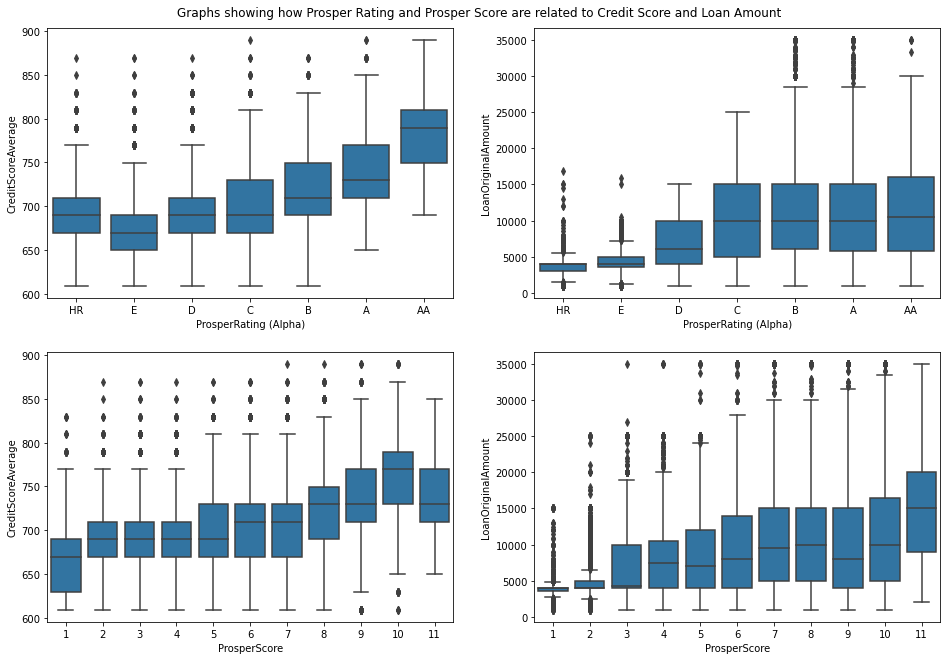

In [31]:
# Plot 'ProsperRating (Alpha)' and 'ProsperScore' against 'CreditScoreAverage' and 'LoanOriginalAmount'

f, axes = plt.subplots(2, 2, figsize = (16, 10))

# set the title
f.subplots_adjust(top=0.95)
f.suptitle("Graphs showing how Prosper Rating and Prosper Score are related to Credit Score and Loan Amount")

vars = ['ProsperRating (Alpha)', 'ProsperScore']
for i in range(len(vars)):
    var = vars[i]
    sns.boxplot(
        data = df, 
        x = var, 
        y = 'CreditScoreAverage', 
        ax = axes[i,0], 
        color = default_color
    )
    sns.boxplot(
        data = df, 
        x = var, 
        y = 'LoanOriginalAmount', 
        ax = axes[i,1], 
        color = default_color
    );    


Generally, with few exceptions, mean Credit Score Average decreases when we move from the best Prosper Rating or Prosper Score to the worst. Loan Amount also has similar relationship with both Prosper Rating and Prosper Score. As both Credit Score and Loan Amount are negatively correlated to Estimated Return and Borrower Rate, their relationship with these two categorical variables are as expected.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Estimated Return has a strong positive correlation with Borrower Rate. However, rate of change is lower in Estimated Return when compared to that of Borrower Rate (i.e slope is less than 1). 

> With Credit Score and Loan Amount, Estimated Return has a negative relationship.

> With the two categorical variables (Prosper Rating or Prosper Score), Estimated Return has a negative relationship as well. It decreases at each categorical level when we move from the best Prosper Rating or Prosper Score to the worst. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Like Estimated Return, Borrower Rate has negative relationship with both Credit Score and Loan Amount.

> Borrower Rate also has similar relationship with both Prosper Rating and Prosper Score as that of Estimated Return, but the amount of change between each categorical levels is very prominent. 

> Both Prosper Rating and Prosper Score have strong positive relationship with one another. 

> Surprisingly, Debt to Income ratio doesn't have linear relationship with any other numeric variables.

<a id='multivariate'></a>
## Multivariate Exploration

> The main thing I want to explore in this part of the analysis is how Prosper Rating and Prosper Score play into the relationship between Estimated Return and Borrower Rate.

> Since I am analyzing from an investor's perspective, I am going to assume investor's expectation is 15% Expected Return, which is 6% above the average Expected Return of 9%.

> First, I will look at the effect of Prosper Rating, first by color encoding and then by faceting.

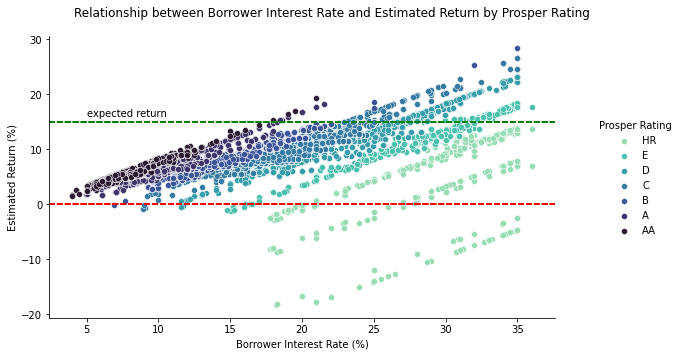

In [32]:
# Plot a graph showing the relationship between 'BorrowerRate' & 'EstimatedReturn' for various 'ProsperRating (Alpha)'

g = sns.FacetGrid(
    data = df, 
    hue = "ProsperRating (Alpha)", 
    height = 5,
    aspect = 1.6,
    palette = 'mako_r'
)

# draw horizontal lines 
g.map(plt.axhline, y=0, ls='--', c='red')
g.map(plt.axhline, y=15, ls='--', c='green')
plt.text(5,16,"expected return")

# plot the graph 
g.map(sns.scatterplot, 'BorrowerRate', 'EstimatedReturn')

# add legend
g.add_legend()
g._legend.set_title("Prosper Rating")

# set the title and the labels
g.set_axis_labels("Borrower Interest Rate (%)", "Estimated Return (%)")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between Borrower Interest Rate and Estimated Return by Prosper Rating");


The general trend is as we move from the worst Prosper Rating to the best, the Borrower Rate decreases (i.e the graph shifts left). At the same time, the Estimated Return increases a bit and then decreases (i.e the graph shifts upwards first and then downwards).

Next, I will look at the same relationship with the help of faceting.

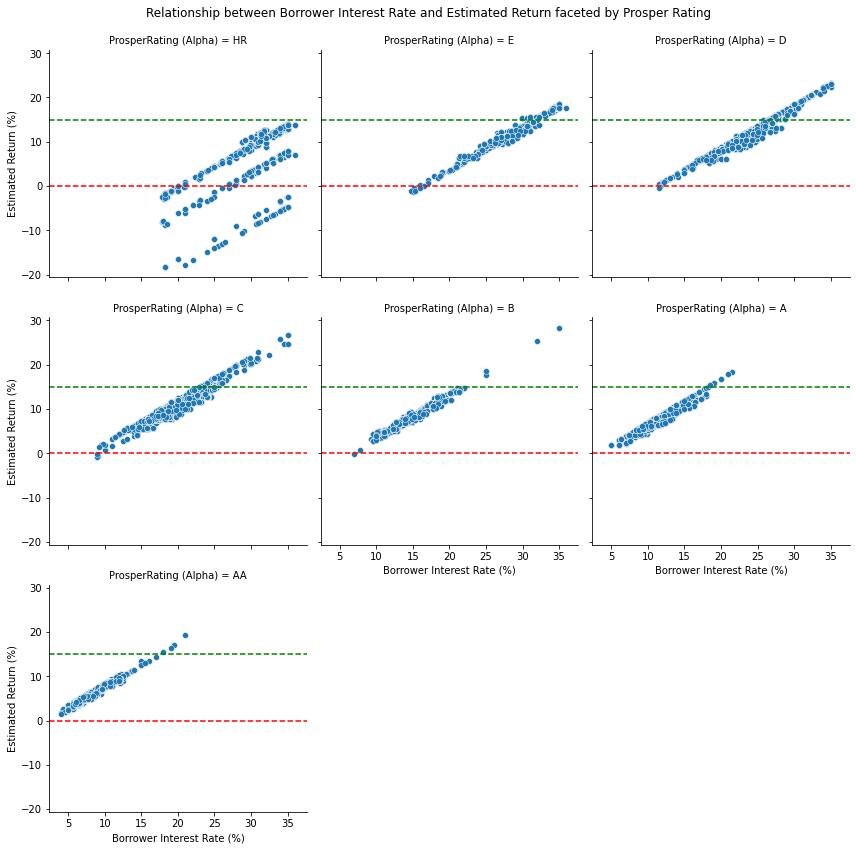

In [33]:
# Plot a graph showing the relationship between 'BorrowerRate' & 'EstimatedReturn' faceted by different 'ProsperRating (Alpha)'

g = sns.FacetGrid(
    data = df, 
    col = "ProsperRating (Alpha)", 
    height = 4,
    palette = 'viridis_r',
    col_wrap = 3
)

# draw horizontal lines
g.map(plt.axhline, y=0, ls='--', c='red')
g.map(plt.axhline, y=15, ls='--', c='green')

# plot the graph 
g.map(sns.scatterplot, 'BorrowerRate', 'EstimatedReturn')

# set the title and the labels
g.set_axis_labels("Borrower Interest Rate (%)", "Estimated Return (%)")
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Relationship between Borrower Interest Rate and Estimated Return faceted by Prosper Rating");

Ignoring the outliers, Prosper Rating 'D' or 'E' provides better Estimated Return.

Next, I will look at the effect of Prosper Score, first by color encoding and then by faceting.

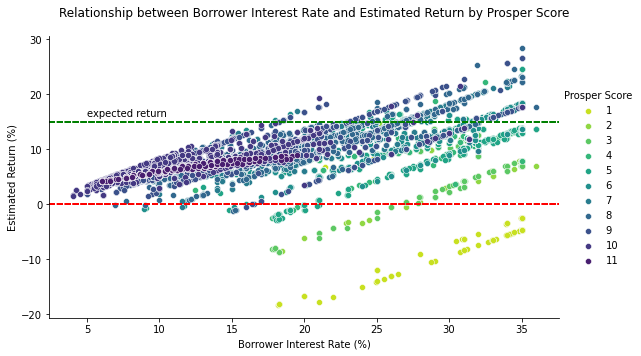

In [34]:
# Plot a graph showing the relationship between 'BorrowerRate' & 'EstimatedReturn' for various 'ProsperScore'

g = sns.FacetGrid(
    data = df, 
    hue = "ProsperScore", 
    height = 5,
    aspect = 1.6,
    palette = 'viridis_r'
)

# draw horizontal lines 
g.map(plt.axhline, y=0, ls='--', c='red')
g.map(plt.axhline, y=15, ls='--', c='green')
plt.text(5,16,"expected return")

# plot the graph 
g.map(sns.scatterplot, 'BorrowerRate', 'EstimatedReturn')

# add legend
g.add_legend();
g._legend.set_title("Prosper Score")

# set the title and the labels
g.set_axis_labels("Borrower Interest Rate (%)", "Estimated Return (%)")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between Borrower Interest Rate and Estimated Return by Prosper Score");

Similar to Prosper Rating, as we move from the worst Prosper Score to the best, the Borrower Rate decreases (i.e the graph shifts left). At the same time, the Estimated Return increases a bit and then decreases (i.e the graph shifts upwards first and then downwards). However, I see more overlaps between Prosper Score levels.

Next, I will look at the same relationship with the help of faceting.

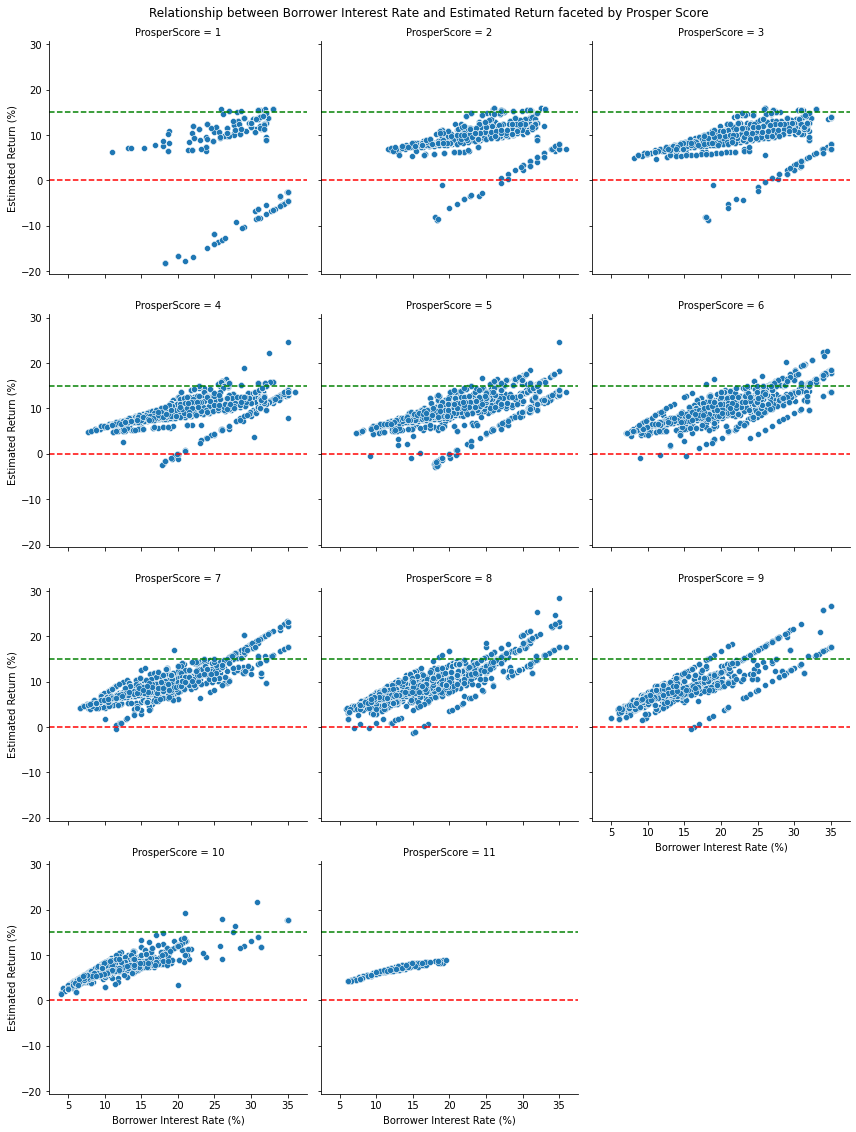

In [35]:
# Plot a graph showing the relationship between 'BorrowerRate' & 'EstimatedReturn' faceted by different 'ProsperScore'

g = sns.FacetGrid(
    data = df, 
    col = "ProsperScore", 
    height = 4,
    palette = 'mako_r',
    col_wrap = 3
)

# draw horizontal lines
g.map(plt.axhline, y=0, ls='--', c='red')
g.map(plt.axhline, y=15, ls='--', c='green')

# plot the graph 
g.map(sns.scatterplot, 'BorrowerRate', 'EstimatedReturn')

# set the title and the labels
g.set_axis_labels("Borrower Interest Rate (%)", "Estimated Return (%)")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Relationship between Borrower Interest Rate and Estimated Return faceted by Prosper Score");

Because of too much outliers and too many levels, it is not very clear which Proper Score provides better Estimated Return.

I will try a different plot: Point plot

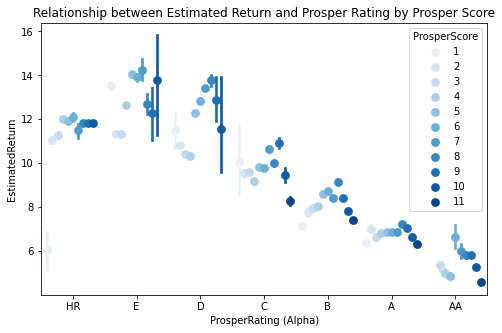

In [36]:
# Plot a pointplot showing the relationship between 'EstimatedReturn', 'ProsperRating (Alpha)' and 'ProsperScore'

f, axes = plt.subplots(figsize = (8, 5))

# set the title and the labels
props = {
    'title': 'Relationship between Estimated Return and Prosper Rating by Prosper Score',
    'xlabel': ' mean Estimated Return (%)',
    'ylabel': 'Prosper Rating'
}
axes.set(**props)

# plot the graph
sns.pointplot(
    data = df,
    x = "ProsperRating (Alpha)", 
    y = "EstimatedReturn",
    hue = "ProsperScore",
    palette = 'Blues',
    linestyles = '',
    dodge = 0.8      
);

The reason why I can't figure out which Prosper Score provides better Estimated Return using the faceted scatter plot is clear from the point plot. For each Prosper Rating, different Prosper Score provides higher Estimated Return. If, as an investor, I am restricting to the E or D Prosper Rating, then Prosper Score of 8 or 9 is what I will go with. 

While the highest mean Estimated Return (for Prosper Rating 'E' and Prosper Score 8) is not 15%, it is very close to it at slightly higher than 14%.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Amongst all, the variables Estimated Return, Borrower Rate and Prosper Rating have clean relationship among each other. Even though each Prosper Rating level has a range of Borrower Rate and the rates overlap between different rating levels, when we move from the worst rating to the best rating, the Borrower Rate decreases. Similarly, the Estimated Return increases first when we move from the worst rating to the best rating and then decreases.

### Were there any interesting or surprising interactions between features?

> From the bivariate plot of Estimated Return and Prosper Score, a score of 8 or 9 is not the one with highest mean Estimated Return. However, when the Estimated Return and Prosper Score are plotted along with Prosper Rating, a score of 8 or 9 is the score with highest return for all but two levels (AA and HR) of Prosper Rating.

<a id='conclusion'></a>
## Conclusions
> I used the data exploration to find out what factors/variables influence the Estimated Return in a positive way for the investor.

> I started the analysis knowing that the Estimated Return is calculated from the Borrower Rate after taking into account any fees, loss due to defaulted loans etc.

> From the analysis, I found out that the two proprietary fields: Prosper Rating and Prosper Score influence the Estimated Return.

>- Prosper Rating: The best rating ("AA") is characterized by lower Borrower Rate, which means lower Estimated Return. The worst rating ("HR") is characterized by higher Borrower Rate, which means higher Estimated Return. However, higher Borrower Rate also comes with higher loss percentage, thereby reducing the Estimated Return. The best bet is the Prosper Rating which is better than the worst (i.e. "E").

>- Proper Score: Prosper Score doesn't have a clear relationship with Estimated Return as the Prosper Rating did. Within each Prosper Rating, the Prosper Score that provides better Estimated Return varies. Prosper Score of 8 or 9 provides better Estimated Return in most of the cases.
